**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

решение задачи бинарной классификации

----

In [1]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

---

In [3]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

# показывать выдачу всех строк ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## генерируем датасет

In [4]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=1_000, centers=2, cluster_std=[1.7,1.8] )

# докидываем свободный член для линейных моделей
# X = np.hstack([X,np.ones((X.shape[0],1))])

print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(1000, 2) (1000,)


In [5]:
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = 'last_expr'

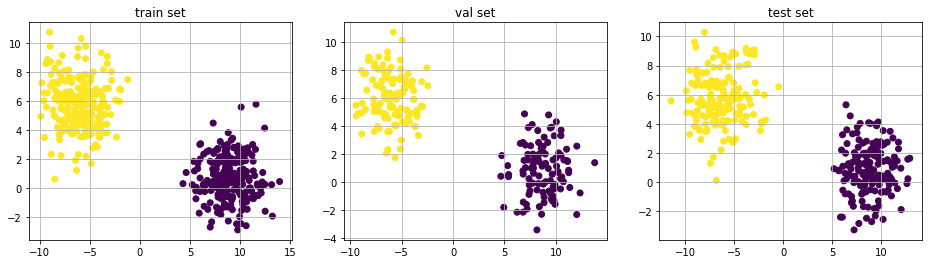

In [6]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

In [7]:
logging.getLogger().setLevel(logging.DEBUG) 
InteractiveShell.ast_node_interactivity = 'all'

## SLP + MSQE + GD

In [8]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {-1,+1}
# y_train, y_val, y_test = [ (y*2)-1 for y in [ y_train, y_val, y_test ] ]

y_train.shape,y_val.shape,y_test.shape

((448, 2), (222, 2), (330, 2))

In [9]:
y_train[:3,:]

array([[0., 1.],
       [1., 0.],
       [1., 0.]])

In [10]:
y_train.sum(axis=0), y_val.sum(axis=0), y_test.sum(axis=0),

(array([231., 217.]), array([106., 116.]), array([163., 167.]))

In [11]:
from lib.model.linear import SLP
# from lib.initiator.linear import NormalInitiatorLinearModel
from lib.initiator.linear import UniformInitiatorLinearModel

%xdel model

model = SLP(
    initiator=UniformInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
        high=.001,
    )
)

model.weight.shape

NameError: name 'model' is not defined


(2, 2)

In [12]:
from lib.loss.msqe import MSQE
loss_train = MSQE(model)
loss_val = MSQE(model)

In [13]:
from lib.optimizer.gd import GD 
from lib.optimizer.lrate import ConstLRA 

lra = ConstLRA(.1)

model = GD( 
    loss=loss_train, 
    loss_val=loss_val, 
    lra=lra,
).fit( 
    data_train=[X_train,y_train], 
    data_val=[X_val,y_val], 
    n_epoch=200,
)

100%|██████████| 200/200 [00:00<00:00, 1389.67it/s, loss=0.189, lr=0.1]


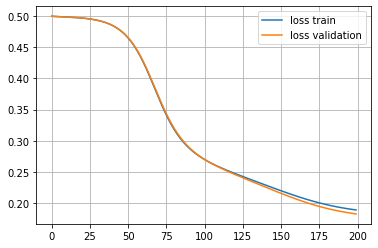

In [14]:
from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

predict is argmax output score vector
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       163
           1       1.00      1.00      1.00       167

    accuracy                           1.00       330
   macro avg       1.00      1.00      1.00       330
weighted avg       1.00      1.00      1.00       330



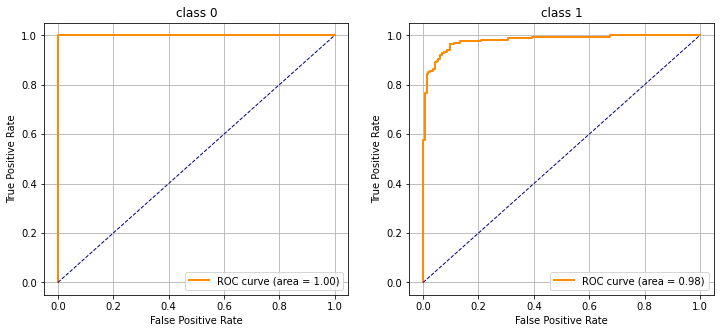

In [15]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test)

In [16]:
model.score(X_test)

array([[0.05892612, 0.70560607],
       [0.98543291, 0.6224536 ],
       [0.0422778 , 0.7787051 ],
       [0.10574955, 0.75704002],
       [0.93926251, 0.51041517],
       [0.98694242, 0.65424745],
       [0.06669757, 0.76213974],
       [0.05428632, 0.72067315],
       [0.02578156, 0.65551295],
       [0.14538792, 0.67956755],
       [0.98084744, 0.5823563 ],
       [0.0965696 , 0.7364689 ],
       [0.16558533, 0.8401037 ],
       [0.07414753, 0.77369095],
       [0.98391357, 0.67828374],
       [0.95014574, 0.43638292],
       [0.97014592, 0.46782274],
       [0.05043102, 0.68478667],
       [0.96745831, 0.49499793],
       [0.07075006, 0.75403168],
       [0.08283427, 0.71127847],
       [0.01612964, 0.7340645 ],
       [0.99321033, 0.62124738],
       [0.98943942, 0.47495981],
       [0.08126649, 0.68185883],
       [0.990805  , 0.4571915 ],
       [0.04729513, 0.72025178],
       [0.96529978, 0.55654844],
       [0.08569341, 0.7858411 ],
       [0.9928835 , 0.47949892],
       [0.

## Softmax  + CCE + GD

In [26]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {0,+1}

y_train.shape,y_val.shape,y_test.shape

((448, 2), (222, 2), (330, 2))

In [27]:
y_train[:3,:]

array([[0., 1.],
       [1., 0.],
       [1., 0.]])

In [28]:
y_train.sum(axis=0), y_val.sum(axis=0), y_test.sum(axis=0),

(array([231., 217.]), array([106., 116.]), array([163., 167.]))

In [29]:
from lib.model.linear import Softmax 
from lib.initiator.linear import NormalInitiatorLinearModel
# from lib.initiator.linear import UniformInitiatorLinearModel

model = Softmax(
    # initiator=UniformInitiatorLinearModel(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
        scale=.1,
    )
)

model.weight.shape

(2, 2)

In [30]:
from lib.loss.crossentropy import CCE # ф-ция потери - категориальная кросс-энтропия
loss_train = CCE(model)
loss_val = CCE(model)

In [31]:
from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.01),
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=100,
)

100%|██████████| 100/100 [00:00<00:00, 1128.20it/s, loss=0.0385, lr=0.01]


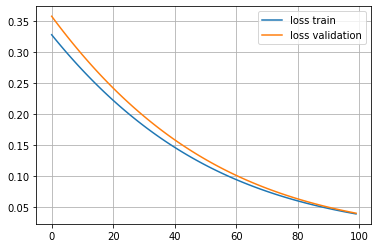

In [32]:
from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

predict is argmax output score vector
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       163
           1       1.00      0.99      1.00       167

    accuracy                           1.00       330
   macro avg       1.00      1.00      1.00       330
weighted avg       1.00      1.00      1.00       330



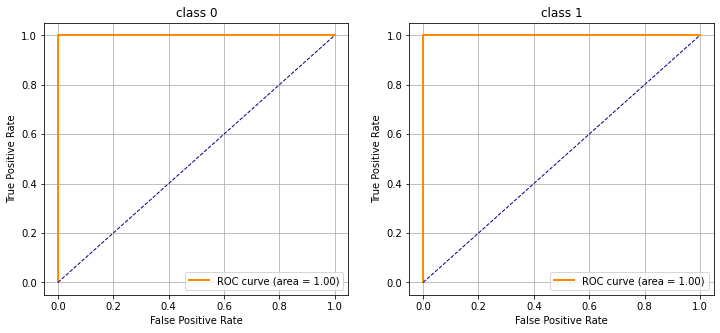

In [33]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test)

In [34]:
# # (model.predict(X_test) == target_test).sum()/len(target_test)
# (model.predict(X_test) != target_test).sum()/len(target_test)
model.score(X_test)

array([[3.02176613e-02, 9.69782339e-01],
       [9.97881418e-01, 2.11858199e-03],
       [2.24284916e-02, 9.77571508e-01],
       [7.94226317e-02, 9.20577368e-01],
       [9.79436656e-01, 2.05633442e-02],
       [9.98302284e-01, 1.69771606e-03],
       [4.13420388e-02, 9.58657961e-01],
       [2.77802864e-02, 9.72219714e-01],
       [8.25826068e-03, 9.91741739e-01],
       [1.06721868e-01, 8.93278132e-01],
       [9.96610786e-01, 3.38921410e-03],
       [6.63420216e-02, 9.33657978e-01],
       [1.86540378e-01, 8.13459622e-01],
       [4.96114472e-02, 9.50388553e-01],
       [9.97831696e-01, 2.16830395e-03],
       [9.82256099e-01, 1.77439006e-02],
       [9.92027279e-01, 7.97272062e-03],
       [2.30455438e-02, 9.76954456e-01],
       [9.91432411e-01, 8.56758851e-03],
       [4.41078317e-02, 9.55892168e-01],
       [5.01458901e-02, 9.49854110e-01],
       [5.05863517e-03, 9.94941365e-01],
       [9.99279476e-01, 7.20524369e-04],
       [9.98209734e-01, 1.79026642e-03],
       [4.576004

## LogisticRegression + CCE + GD

In [50]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis] for t in [ target_train, target_val, target_test ] ]
# выход = метка класса

y_train.shape,y_val.shape,y_test.shape

((448, 1), (222, 1), (330, 1))

In [51]:
from lib.model.linear import SLP
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP( # логистическая регрессия 1./(1.+np.exp(-x.dot(w)) )
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

model.weight.shape

(2, 1)

In [52]:
from lib.loss.crossentropy import BCE # ф-ция потери - кросс-энтропия
loss_train = CCE(model)
loss_val = CCE(model)

In [53]:
from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.1),
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=25,
)

100%|██████████| 25/25 [00:00<00:00, 1380.00it/s, loss=0.00513, lr=0.1]


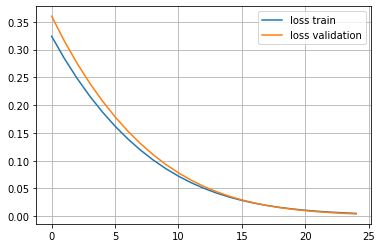

In [54]:
from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

In [55]:
# target_train

In [56]:
from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

score threshold to predict is 0.7547258113399641
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       163
           1       1.00      0.99      1.00       167

    accuracy                           1.00       330
   macro avg       1.00      1.00      1.00       330
weighted avg       1.00      1.00      1.00       330



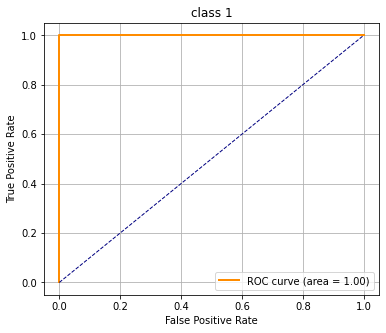

In [57]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test,figsize=(6,5))